# Import Packages

In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import gc
from torchvision import datasets,transforms
from torchsummary import summary
from torch.utils.data import DataLoader,TensorDataset

In [ ]:
#pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/Work/Projects/Weizmann/Input
!ls

Mounted at /content/drive/
/content/drive/My Drive/Work/Projects/Weizmann/Input
Discriminator_GAN_0.pt
GAN_0.pt
gan_plot.png
gendata_template-flat_signal-gaus-higstat_test.npy
gendata_template-flat_signal-gaus-lowstat_test.npy
gendata_template-flat_signal-rect-higstat_test.npy
gendata_template-flat_signal-rect-lowstat_test.npy
gendata_template-flat_train.npy
gendata_template-simul_signal-gaus-higstat_test.npy
gendata_template-simul_signal-gaus-lowstat_test.npy
gendata_template-simul_signal-rect-higstat_test.npy
gendata_template-simul_signal-rect-lowstat_test.npy
gendata_template-simul_train.npy
Generator_GAN_0.pt
generator.pt
matrix_error_bkg_only.npy
matrix_error_bkg_only_val.npy
models
old


# Hyperparameters

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 10


# Import Data

## Training Set

Here is the code to transform the image provided by the CERN into difference of image normalized like explain in the READ ME.

In [ ]:
# X_bkg=np.load("gendata_template-flat_train.npy")
# X_train=X_bkg[:600000,]
# X_train_1=np.zeros([np.int(X_train.shape[0]/2), 28, 28], dtype=np.float32)
# for i in range(np.int(X_train.shape[0]/2)):
#   X_train_1[i]=(X_train[i]-X_train[i+np.int(X_train.shape[0]/2)])/(6*np.sqrt(X_train[i]+X_train[i+np.int(X_train.shape[0]/2)]))

# X_bkg=np.load("gendata_template-simul_train.npy")
# X_train=X_bkg[:600000,]
# X_train_2=np.zeros([np.int(X_train.shape[0]/2), 28, 28], dtype=np.float32)
# for i in range(np.int(X_train.shape[0]/2)):
#   X_train_2[i]=(X_train[i]-X_train[i+np.int(X_train.shape[0]/2)])/(6*np.sqrt(X_train[i]+X_train[i+np.int(X_train.shape[0]/2)]))
# X_train=np.append(X_train_1,X_train_2,axis=0)
# np.save(os.path.join("matrix_error_bkg_only.npy"), X_train)

Since this operation take time we saved the result of the code below and import it each time we need to work.

In [ ]:
X_train=np.load("matrix_error_bkg_only.npy")

In [ ]:
X_train=X_train[:512000,]
# since we had an issue with the size of the batch we had to take a sample with a size of the batch being a multipile of th etotal for ex 128 *4000=512000

In [ ]:
def pre_process(X):
    X=X.reshape(len(X),1,X.shape[1],X.shape[2]) #len(X_train) is the  the first dim of X ie number of image
    return X
X_train=pre_process(X_train)

In [ ]:
X = torch.FloatTensor( X_train )
Y = torch.FloatTensor( np.ones(len(X_train)) ).unsqueeze(1)
dataset = TensorDataset(X, Y)
train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)#num_workers=0

In [ ]:
del X_train,X,Y,dataset
#to clear the memory
gc.collect()

88

## Validation and Testing Set

In [ ]:
X_bkg=np.load("gendata_template-simul_train.npy")
X_val_A=X_bkg[600000:,]
X_bkg_sig=np.load('gendata_template-simul_signal-gaus-lowstat_test.npy')
X_val_B=X_bkg_sig[0,]
X_test=X_bkg_sig[1,]

In [ ]:
X_val_bs=np.zeros([X_val_A.shape[0], 28, 28], dtype=np.float32)
X_test_bs=np.zeros([X_test.shape[0], 28, 28], dtype=np.float32)

for i in range(X_val_A.shape[0]):
  X_val_bs[i]=(X_val_A[i]-X_val_B[i])/(6*np.sqrt(X_val_A[i]+X_val_B[i]))
  X_test_bs[i]=(X_val_A[i]-X_test[i])/(6*np.sqrt(X_val_A[i]+X_test[i]))

In [ ]:
del X_bkg,X_bkg_sig,X_val_A,X_val_B,X_test
gc.collect()

159

In [ ]:
# We explicitly set shuffle = False in case of test_dl because we need unshuffled labels at the end to draw confusion matrix.
sample_shape=600000
X_val = X_val_bs[:sample_shape,]
X_val = pre_process(X_val)
X = torch.FloatTensor( X_val )
Y = torch.FloatTensor( np.ones(len(X_val)) ).unsqueeze(1)
dataset = TensorDataset(X, Y)
val_loader = DataLoader(dataset,batch_size=50,shuffle=False)

X_test = X_test_bs[:sample_shape,]
X_test = pre_process(X_test)
X = torch.FloatTensor( X_test )
Y = torch.FloatTensor( np.ones(len(X_test)) ).unsqueeze(1)

dataset = TensorDataset(X, Y)
test_loader = DataLoader(dataset,batch_size=50,shuffle=False)


# We explicitly set shuffle = False in case of test_dl because we need unshuffled labels at the end to draw confusion matrix.
sample_shape_light=20000
X_val = X_val_bs[:sample_shape_light,]
X_val = pre_process(X_val)
X = torch.FloatTensor( X_val )
Y = torch.FloatTensor( np.ones(len(X_val)) ).unsqueeze(1)
dataset = TensorDataset(X, Y)
val_loader_light = DataLoader(dataset,batch_size=50,shuffle=False)

X_test = X_test_bs[:sample_shape_light,]
X_test = pre_process(X_test)
X = torch.FloatTensor( X_test )
Y = torch.FloatTensor( np.ones(len(X_test)) ).unsqueeze(1)

dataset = TensorDataset(X, Y)
test_loader_light = DataLoader(dataset,batch_size=50,shuffle=False)

In [ ]:
del X_val_bs,X_val,X,Y,dataset,X_test_bs
gc.collect()

88

In [ ]:
dataiter=iter(train_loader)
images, labels=dataiter.next()
print(torch.min(images),torch.max(images))

# to consider to bring that between 0 and 1 by min-max, but how to do on test set?

tensor(-0.7160) tensor(0.8054)


# Models

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
    #128x14x14
    self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(256)
    #256x7x7
    self.conv3 = nn.Conv2d(256, 1, 7, 1, 0)
      
  def forward(self, input):
    x = torch.nn.functional.leaky_relu(self.conv1(input), 0.2)
    x = torch.nn.functional.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)   
    x = torch.sigmoid(self.conv3(x))
    x=x.reshape(-1,1)
    return x.cuda()

In [ ]:
class Autoencoder(nn.Module):
  # output size = (Input row - Filter row + 2 * Pad) / Stride + 1

  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size= 3, stride=2,padding= 1),
                              nn.Tanh(),
                              nn.Conv2d(16, 32,kernel_size= 3, stride=2,padding= 1),
                              nn.Tanh(),
                              nn.Conv2d(32, 64, 7))
   
  # output size = (input size - 1) * stride - 2* padding + (kernel_size - 1) + 1

    self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 7),#32,7,7
                                 nn.Tanh(),
                                 nn.ConvTranspose2d(32, 16, kernel_size= 3, stride=2,padding= 1,output_padding=1),#output_paddig let us add a dimension from 16,13,13 to 16,14,14
                                 nn.Tanh(),
                                 nn.ConvTranspose2d(16, 1, kernel_size= 3, stride=2,padding= 1,output_padding=1),# form 1,27,27 to 1,28,28 with output_padding
                                 nn.Tanh())#,nn.ReLU())
  
  def forward(self, input):
    encoded = self.encoder(input)
    # at this point the representation is (1, 1, 32)  
    decoded = self.decoder(encoded)
    return decoded.cuda()

In [ ]:
discriminator = Discriminator().to(device=device)
autoencoder=Autoencoder().to(device=device)

In [ ]:
summary(autoencoder,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              Tanh-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              Tanh-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
   ConvTranspose2d-6             [-1, 32, 7, 7]         100,384
              Tanh-7             [-1, 32, 7, 7]               0
   ConvTranspose2d-8           [-1, 16, 14, 14]           4,624
              Tanh-9           [-1, 16, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             145
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 210,369
Trainable params: 210,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
loss_function = nn.MSELoss()
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.99))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-8, betas=(0.5, 0.99))

In [ ]:
outputs=[]
for epoch in range(NUM_EPOCHS-8):
  for (img,_) in train_loader:
    recon=autoencoder(img.cuda())
    loss=loss_function(recon,img.cuda())
    optimizer_autoencoder.zero_grad()
    loss.backward()
    optimizer_autoencoder.step()
  print(f'Epoch:{epoch+1},Loss:{loss.item():.4f}')
  outputs.append((epoch,img,recon))

Epoch:1,Loss:0.0255
Epoch:2,Loss:0.0254


In [ ]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): Tanh()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Tanh()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
losses_val=[]
with torch.no_grad():
    for images, _ in val_loader:
        outputs = autoencoder(images.cuda())
        loss=loss_function(outputs,images.cuda()).cpu()
        losses_val.append(loss)

In [ ]:
losses_test=[]
with torch.no_grad():
    for images, _ in test_loader:
        outputs = autoencoder(images.cuda())
        loss=loss_function(outputs,images.cuda()).cpu()
        losses_test.append(loss)

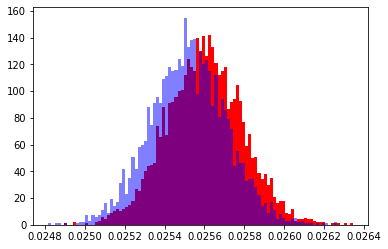

In [ ]:
fig=plt.figure()
begin_bins_bo=min(np.min(losses_test),np.min(losses_val))
end_bins_bo=max(np.max(losses_test),np.max(losses_val))

plt.hist(losses_test,bins=np.linspace(begin_bins_bo,end_bins_bo,100),color='r')
plt.hist(losses_val,bins=np.linspace(begin_bins_bo,end_bins_bo,100),color='b',alpha=0.5)
plt.show()

In [ ]:
# Training GAN with autoencoder instead of the generator
for epoch in range(NUM_EPOCHS):
    for n, (real_samples,real_samples_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = real_samples_labels.to(device=device)
        
        autoencoded_samples = autoencoder(real_samples)

        autoencoded_samples_labels = torch.zeros((BATCH_SIZE, 1)).to(device=device)
        all_samples = torch.cat((real_samples, autoencoded_samples))
        all_samples_labels = torch.cat((real_samples_labels, autoencoded_samples_labels))

        if (n %1000):
       
          # Training the discriminator
          discriminator.train()
          autoencoder.eval()
          discriminator.zero_grad()
          output_discriminator = discriminator(all_samples)
          loss_discriminator = loss_function(output_discriminator, all_samples_labels)
          loss_discriminator.backward()
          optimizer_discriminator.step()
        else:
         
          # Training the autoencoder

          autoencoder.train()
          discriminator.eval()
          autoencoder.zero_grad()
          autoencoded_samples = autoencoder(real_samples)
          output_discriminator_autoencoded = discriminator(autoencoded_samples)

          #print(n,output_discriminator_generated.shape,real_samples_labels.shape)
          
          loss_autoencoder = loss_function(output_discriminator_autoencoded, real_samples_labels)
          loss_autoencoder.backward()
          optimizer_autoencoder.step()

        # Show loss
        if n == BATCH_SIZE +1:
          
          accuracy_real_samples=torch.sum(discriminator(real_samples)).item()/len(real_samples)
          accuracy_autoencoded_samples=torch.sum(discriminator(autoencoded_samples)).item()/len(autoencoded_samples)
          output_discriminator = discriminator(all_samples)
          loss_discriminator = loss_function(output_discriminator, all_samples_labels)
          output_discriminator_autoencoded = discriminator(autoencoded_samples)
          loss_autoencoder = loss_function(output_discriminator_autoencoded, real_samples_labels)
          print(f"Epoch: {epoch} Loss D.: {loss_discriminator}",f"Epoch: {epoch} Loss A.: {loss_autoencoder}",accuracy_real_samples,accuracy_autoencoded_samples)


Epoch: 0 Loss D.: 0.5273748636245728 Epoch: 0 Loss A.: 0.003534692106768489 0.6676150560379028 0.9405525922775269
Epoch: 1 Loss D.: 0.5362308621406555 Epoch: 1 Loss A.: 0.0013041130732744932 0.7000677585601807 0.9638887643814087
Epoch: 2 Loss D.: 0.5300866365432739 Epoch: 2 Loss A.: 0.0010222569108009338 0.7270814180374146 0.9680279493331909
Epoch: 3 Loss D.: 0.5241502523422241 Epoch: 3 Loss A.: 0.0007911890279501677 0.752621591091156 0.9718725085258484
Epoch: 4 Loss D.: 0.5172597169876099 Epoch: 4 Loss A.: 0.0006418797420337796 0.7882343530654907 0.9746652841567993
Epoch: 5 Loss D.: 0.5126756429672241 Epoch: 5 Loss A.: 0.0005721222842112184 0.8079774379730225 0.9760814905166626
Epoch: 6 Loss D.: 0.5109878778457642 Epoch: 6 Loss A.: 0.0004216425877530128 0.8224747180938721 0.9794663786888123
Epoch: 7 Loss D.: 0.5080418586730957 Epoch: 7 Loss A.: 0.00033562188036739826 0.844164252281189 0.9816802144050598


KeyboardInterrupt: ignored

# From Autoencoder point of vue

In [ ]:
losses_val=[]
with torch.no_grad():
    for images, _ in val_loader:
        outputs = autoencoder(images.cuda())
        loss=loss_function(outputs,images.cuda()).cpu()
        losses_val.append(loss)

In [ ]:
losses_test=[]
with torch.no_grad():
    for images, _ in test_loader:
        outputs = autoencoder(images.cuda())
        loss=loss_function(outputs,images.cuda()).cpu()
        losses_test.append(loss)

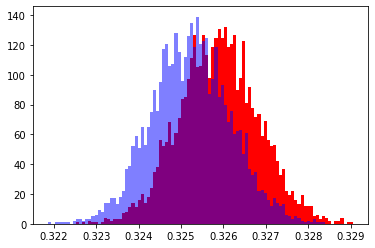

In [ ]:
fig=plt.figure()
begin_bins_bo=min(np.min(losses_test),np.min(losses_val))
end_bins_bo=max(np.max(losses_test),np.max(losses_val))

plt.hist(losses_test,bins=np.linspace(begin_bins_bo,end_bins_bo,100),color='r')
plt.hist(losses_val,bins=np.linspace(begin_bins_bo,end_bins_bo,100),color='b',alpha=0.5)
plt.show()

# From Discriminator point of vue

In [ ]:
output_val=[]
final_output=[]
for (real_samples,_) in val_loader_light:
  output_val=discriminator(real_samples.cuda())#.to(device=device))
  final_output.append(output_val)
result_val = torch.cat(final_output, dim=1)#.reshape(20000) 

In [ ]:
output_val=result_val.reshape(sample_shape_light,1).cpu().detach().numpy()

In [ ]:
del result_val,final_output
gc.collect()

15831

In [ ]:
output_test=[]
final_output=[]
for (real_samples,_) in test_loader_light: 
  output_test=discriminator(real_samples.cuda())#.to(device=device))
  final_output.append(output_test)
result_test = torch.cat(final_output, dim=1)

In [ ]:
output_test=result_test.reshape(20000,1).cpu().detach().numpy()

In [ ]:
del result_test,final_output
gc.collect()

176

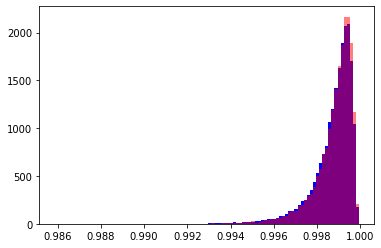

In [ ]:
fig=plt.figure()
begin_bins= min(np.min(output_val),np.min(output_test))
end_bins = max(np.max(output_val),np.max(output_test))

plt.hist(output_val,bins=np.linspace(begin_bins,end_bins,100),color='b')
plt.hist(output_test,bins=np.linspace(begin_bins,end_bins,100),color='r',alpha=0.5)
plt.show()

In [ ]:
# Saves the model after the last epoch
torch.save({'discriminator_state_dict': discriminator.state_dict(), 'autoencoder_state_dict': autoencoder.state_dict()}, 'GANa_0' + '.pt')
torch.save({'discriminator_state_dict': discriminator.state_dict()}, 'Discriminator_GANa_0' + '.pt')
torch.save({'autoencoder_state_dict': autoencoder.state_dict()}, 'Autoencoder_GANa_0' + '.pt')

NameError: ignored

In [ ]:
autoencoder = Autoencoder()
checkpoint=torch.load('Autoencoder_GANa_0.pt')
autoencoder.load_state_dict(checkpoint['autoencoder_state_dict'], strict=False)
autoencoder.eval()